This notebook reads in output files from SCALE simulations to generate a large dataset of uranium fission product gamma-ray measurements with variable enrichment and decay time. The SCALE irradiations were performed in ORNL's HFIR neutron field - a highly thermal spectrum. That dataset is then fed into machine learning predictions algorithms via scikit-learn to develop prediction models of uranium enrichment. The ability of models to generalize to predictions outside of trained decay times and enrichment levels is examined. The accuracy of the models is characterized as a function of multi-variate parameters. The suitability of various learning algorithms for this task is compared. This process may be iterated with a fast spectrum neutron field.

# Setting up the notebook

In [4]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
cd /Users/adam/Box Sync/Dissertation/SCALE

/Users/adam/Box Sync/Dissertation/SCALE


# Importing and preprocessing data

We will start with the simplest scenario: binary classification of U-235 versus U-238. We import gamma-ray data of each isotope measured at decay times ranging from 0 days to 1 year post-irradiation. There are 180 measurements of each isotope broken down into 100 gamma-ray energy groups from 0 to 2.5 MeV.

In [6]:
u235 = pd.read_csv('u235_100Egroups.csv').as_matrix()
u238 = pd.read_csv('u238_100Egroups.csv').as_matrix()

The required format for analysis is one "observation", or measurement, per ROW, not column. Therefore we must transpose the data.

In [7]:
u235 = u235.T
u238 = u238.T

# Functions

Here I write a few functions which will be used later to: 

1. Create data of intermediate enrichment levels on-the-fly by manipulating the imported SCALE data of each isotope, 

2. Build, grade, and visualize the results of models constructed with varying training/testing splits and measurement replicates.

I also import a useful function for creating training/testing splits of data.

I also create a wrapper function to automate a few of these steps.

centrifuge(w, mode) generates a matrix X which has user-specified n levels of uranium enrichment. There are 180 observations, or rows, of gamma-ray data per enrichment level. It also generates the accompanying y matrix which labels each row with the correct enrichment value. 

Note: Specifying an n value of 1 will return the previously used X matrix, which consists of pure u238 and pure u235. The mode parameter tells the function whether to generate classification ('clf') data or regression ('reg') data, depending on the type of model for which the data is constructed.

In [8]:
def centrifuge(w, mode):
    X = u238
    if mode=='clf':
        y = np.zeros([180], dtype=str)
    elif mode=='reg':
        y = np.zeros([180], dtype=float)
    else:
        print('Please specify classification (clf) or regression (reg).')
    for i in range(1,w+1):
        enrichment = (float(i)/float(w))
        enriched_u = enrichment * u235 + (1 - enrichment) * u238
        X = np.append(X, enriched_u, axis=0)
        if mode=='clf':
            category = str(enrichment)
        elif mode=='reg':
            category = float(enrichment)
        else:
            print('Please specify classification (clf) or regression (reg).')
        for j in range(0, 180):
            y = np.append(y, category)
    return X, y
        

grader(results,y_test) checks the predictions of a model and compares it to the known answers, and provides a score of the model accuracy as a percentage.

In [9]:
def grader(results,y_test):
    if len(results)==len(y_test):
        pass
    else:
        print "Mismatch in predicted and testing data!"
    score=0
    for i in range(0,len(y_test)-1):
        if results[i]==y_test[i]:
            score+=1
        else:
            pass
    grade = 100 * score/len(results)
    # print('The score of the algorithm is')
    # print(grade)
    return grade

The scikit-learn function model_selection.train_test_split can create training/testing splits of data and labels with user specified splitting factors.

In [10]:
from sklearn import model_selection

multi_grader_LinearSVC(n,m) serves as a wrapper for grader and model_selection.train_test_split, while also adding the capability to replicate data splitting, model creation, model grading, and result visualization across a range of user-specified training/testing splits. The user enters a number n of training/testing splits, and a number m of replicate measurements to make for each training/testing split.

Note: Currently this wrapper function is specific to LinearSVC models. It will be useful to create a more generalized wrapper function that can call any learning algorithm later.

In [11]:
def multi_grader_LinearSVC(n,m):
    grades = np.array([])
    train_fractions = np.array([])
    for i in range (1,n):
        test_fraction = (float(i)/float(n))
        for j in range(1,m):
            X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
            X, y, test_size = test_fraction)
            clf = svm.LinearSVC()
            clf.fit(X_train,y_train)
            pred = clf.predict(X_test)
            new_grade = grader(pred, y_test)
            grades = np.append(grades,new_grade)
            train_fractions = np.append(train_fractions,1-test_fraction)
    train_fractions = np.around(train_fractions, 2)
    out = list(zip(train_fractions, grades))
    sns.set_style('dark')
    sns.set_context("talk")
    figure = sns.boxplot(x=train_fractions, y=grades, color='orange').set(xlabel='Training Fraction', ylabel = 'Grade (%)')
    # return out, train_fractions, grades, figure
    return figure

multi_grader_RidgeRegression(a,b,n) tests the RidgeRegression model at a user-specified 'n' training split (between 0 and 1), for 'a' different alpha values ranging from 0 to 'b'. The results are then placed into  boxplots which show the absolute values of the errors in prediction as a function of alpha values.

Let's adjust multi_grader_RidgeRegression to make logarithmically-spaced alpha regularization values. Now the regularization values are powers of ten ranging from -a to +a.

In [55]:
def multi_grader_RidgeRegression(a,b,n):
    errors = np.array([])
    alphas = np.array([])
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=n)
    for i in range(-a,a+1):
        #alpha_fraction = np.ln((float(i)*b/float(a)))
        alpha_fraction = 10 ** (-i)
        reg = linear_model.Ridge(alpha=alpha_fraction)
        reg.fit(X_train,y_train)
        pred = reg.predict(X_test)
        error=abs(pred-y_test)
        errors = np.append(errors,error)
        for k in range(0,len(error)):
            alphas = np.append(alphas, alpha_fraction)
        alphas = np.around(alphas, 2)
        out = list(zip(alphas, errors))
        sns.set_style('dark')
        sns.set_context('talk')
    figure = sns.boxplot(x=alphas, y=errors, color='orange').set(xlabel='Regularization Parameter', ylabel = 'Error Absolute Values')
    return figure

# Importing and preparing learning algorithms

We will study a few learning algorithms:

1. The classification algorithm 'LinearSVC'
2. The regression algorithm 'Lasso'

In [13]:
from sklearn import svm #for LinearSVC

In [14]:
from sklearn import linear_model #for Lasso

# Model Testing

# Classification Model

We begin by testing the 'LinearSVC' classification algorithm. We build models based on varying numbers of enrichment 'categories', and grade their prediction accuracies as a function of training fraction. The results are then summarized with one boxplot demonstrating distribution of grades as a function of training fraction for each number of enrichment 'categories'.

[Text(0,0.5,u'Grade (%)'), Text(0.5,0,u'Training Fraction')]

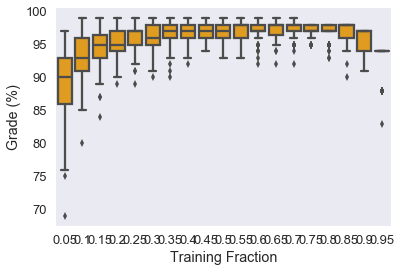

In [13]:
X, y = centrifuge(1,'clf')
multi_grader_LinearSVC(20,100)

[Text(0,0.5,u'Grade (%)'), Text(0.5,0,u'Training Fraction')]

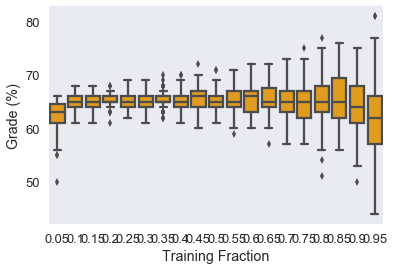

In [14]:
X, y = centrifuge(2,'clf')
multi_grader_LinearSVC(20,100)

[Text(0,0.5,u'Grade (%)'), Text(0.5,0,u'Training Fraction')]

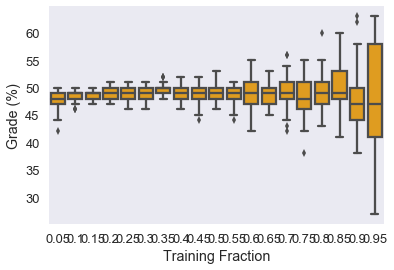

In [15]:
X, y = centrifuge(3,'clf')
multi_grader_LinearSVC(20,50)

[Text(0,0.5,u'Grade (%)'), Text(0.5,0,u'Training Fraction')]

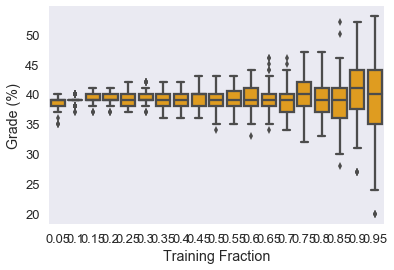

In [16]:
X, y = centrifuge(4,'clf')
multi_grader_LinearSVC(20,100)

[Text(0,0.5,u'Grade (%)'), Text(0.5,0,u'Training Fraction')]

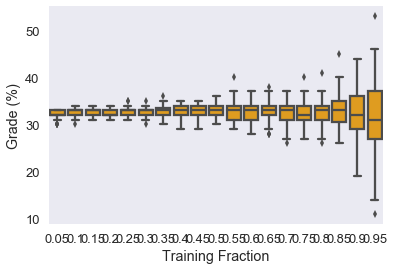

In [17]:
X, y = centrifuge(5,'clf')
multi_grader_LinearSVC(20,100)

Here are the main observations from the above set of experiments:

1. The best results are usually obtained with a training/testing split of 50%. However, there are significant gains in 'Grade' when the training fraction is increased from 5% to about 20%. After that there are strongly diminishing returns in 'Grade' when further increasing the training fraction.

2. The classification accuracy of the model decreases significantly with each increase in number of enrichment regimes. However, in all situations, the models perform much better than random guessing.

# Regression Model

The first regression model that we will test is the Lasso.

In [21]:
reg = linear_model.Lasso(alpha=0.1)
X, y = centrifuge(3,'reg')
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.5)
reg.fit(X_train,y_train)
pred = reg.predict(X_test)
score = grader(pred,y_test)
errors=abs(pred-y_test)

In [24]:
avg_error = np.average(errors)
avg_error

0.044737565882256886

(array([ 11.,   8.,   9.,   9.,   6.,   9.,   6.,   5.,   4.,   5.,   7.,
          4.,  10., 101.,   8.,   5.,   8.,   4.,   7.,  11.,   1.,  10.,
         15.,   4.,   5.,   4.,   3.,   6.,   4.,   3.,   5.,   6.,   3.,
          2.,   2.,   3.,   4.,   3.,   1.,   2.,   5.,   3.,   0.,   0.,
          1.,   0.,   1.,   1.,   0.,   2.,   1.,   0.,   1.,   1.,   1.,
          1.,   2.,   1.,   0.,   1.,   0.,   1.,   2.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          1.]),
 array([1.63744205e-04, 2.35538994e-03, 4.54703567e-03, 6.73868141e-03,
        8.93032714e-03, 1.11219729e-02, 1.33136186e-02, 1.55052643e-02,
        1.76969101e-02, 1.98885558e-02, 2.20802015e-02, 2.42718473e-02,
        2.64634930e-02, 2.86551387e-02, 3.08467845e-02, 3.30384302e-02,
        3.52300759e-02, 3.7421

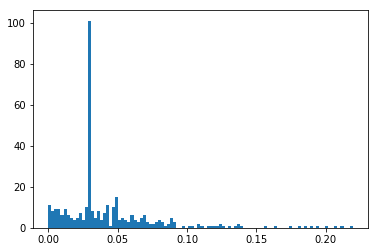

In [22]:
plt.hist(errors,bins=100)

Let's look at another regression model: Ridge Regression

This function runs ridge regression for a specified number of enrichment levels, test fraction, and iterations at each set of parameters. At each enrichment level, a boxplot will be made showing the distribution of average errors each time the code iterates at that value. The result will be a boxplot showing distribution of average errors for n iterations as a function of w enrichment levels.

In [25]:
def ridge_regression_variations(w_max, test_fraction, n):
    enrichments = np.array([])
    avg_error = np.array([])
    for i in range(1,w_max+1):
        X, y = centrifuge(i,'reg')
        reg = linear_model.Ridge()
        for j in range(0,n):
            X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
                X, y, test_size = test_fraction)
            reg.fit(X_train, y_train)
            pred = reg.predict(X_test)
            errors=abs(pred-y_test)
            average = np.average(errors)
            avg_error = np.append(avg_error, average)
            enrichments = np.append(enrichments, i+1)
            figure = sns.boxplot(x=enrichments, y=avg_error).set(xlabel='Number of enrichment levels', ylabel='Average error in prediction', yscale='log', title='Number of replicates:' + str(n))
    return figure

/Users/adam/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.02514549765e-22 / 1.11022302463e-16
  RuntimeWarning)
/Users/adam/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5416927806e-22 / 1.11022302463e-16
  RuntimeWarning)
/Users/adam/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.23868097574e-22 / 1.11022302463e-16
  RuntimeWarning)
/Users/adam/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not gua

[None,
 Text(0,0.5,u'Average error in prediction'),
 Text(0.5,0,u'Number of enrichment levels'),
 Text(0.5,1,u'Number of replicates:10')]

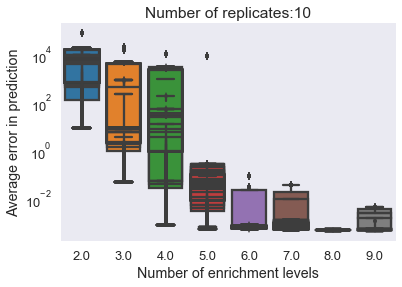

In [31]:
ridge_regression_variations(8,0.5,10)

/Users/adam/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.002149e-19
  overwrite_a=True).T
/Users/adam/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.134998e-21
  overwrite_a=True).T


[Text(0,0.5,u'Error Absolute Values'), Text(0.5,0,u'Regularization Parameter')]

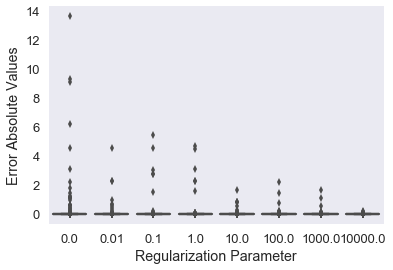

In [56]:
multi_grader_RidgeRegression(4,10,0.5)

In [58]:
def single_ridge_regression(w, test_fraction, n_bins, xmin, xmax, solver):
    X, y = centrifuge(w,'reg')
    reg = linear_model.Ridge(solver=solver)
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
        X, y, test_size = test_fraction)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    errors = abs(pred - y_test)
    avg_error = np.average(errors)
    plt.hist(errors, bins = n_bins)
    plt.xlim(xmin, xmax)
    plt.xlabel('Absolute error in prediction')
    plt.ylabel('Frequency')
    plt.title('Distribution of absolute errors')
    return avg_error

The promising solvers appear to be: svd, cholesky, and sparse_cg

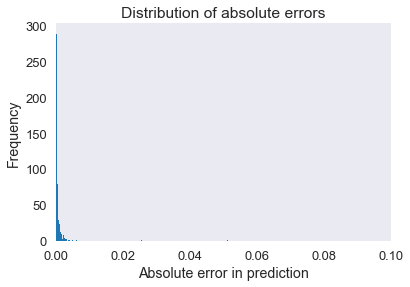

In [69]:
rr_svd = single_ridge_regression(5,0.5,500, 0, 0.1, 'svd')

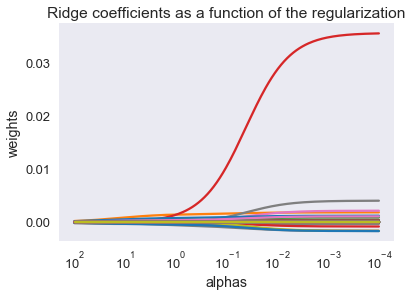

In [80]:
n_alphas = 200
alphas = np.logspace(-4,2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alphas')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

0.000652754531033244

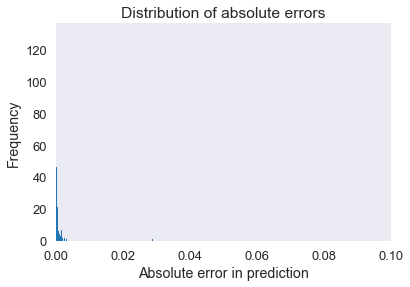

In [62]:
single_ridge_regression(5,0.5,500, 0, 0.1, 'cholesky')

0.14138069286851848

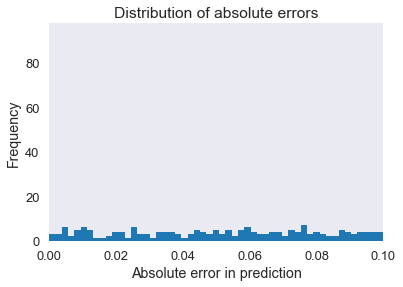

In [63]:
single_ridge_regression(5,0.5,500, 0, 0.1, 'lsqr')

0.022608572143524814

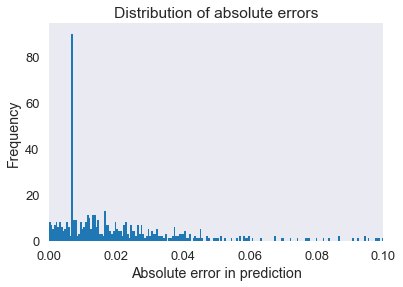

In [64]:
single_ridge_regression(5,0.5,500, 0, 0.1, 'sparse_cg')

0.23120437427469406

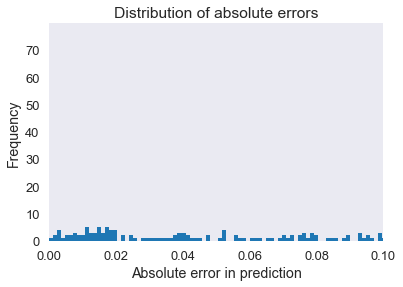

In [65]:
single_ridge_regression(5,0.5,500, 0, 0.1, 'sag')

0.24085253466676013

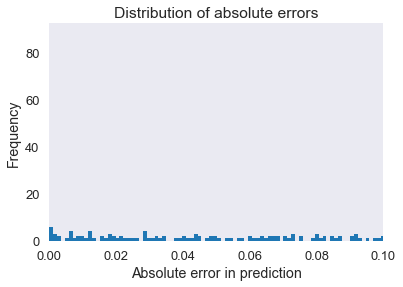

In [66]:
single_ridge_regression(5,0.5,500, 0, 0.1, 'saga')

0.0005148026476750011

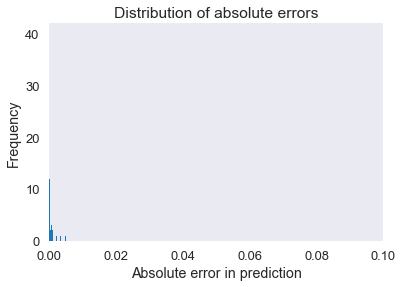

In [68]:
single_ridge_regression(5, 0.5, 500, 0, 0.1, 'auto')

^These are the results of RidgeRegression when presented with 4 enrichment levels. Almost all of the errors are less than 1% off!

Let's build a multi-variate ridge regression model. For this experiment, we will simultaneously perform predictions on two parameters: the enrichment and decay time of the uranium. We must therefore construct a new targets array y that includes decay times...

We can also test some of the other features in ridge regression:
1. We still need to look at logarithmically spaced regularization parameters.
2. We should investigate the different solver options: solver= auto, svd, cholesky, lsqr, sparse_cg, sag, saga

Let's build the multivariate labels array y for simultaneous predictions on decay time and enrichment.

Here we begin utilizing the full capabilities of pandas for dataframe manipulation, which will eventually lead to a much smoother and more optimized workflow that what we have had up to this point, utilizing numpy arrays and manual tracking of data labels.

In [100]:
datau235 = pd.read_csv('u235.csv')
datau238 = pd.read_csv('u238.csv')
dfu235 = pd.DataFrame(datau235)
dfu238 = pd.DataFrame(datau235)
dfu235 = dfu235.T
dfu238 = dfu238.T
dfu235.columns = dfu235.iloc[0]
dfu238.columns = dfu238.iloc[0]
dfu235 = dfu235.drop('Energy')
dfu238 = dfu238.drop('Energy')
dfu235.index.name = 'DecayTimeDays'
dfu238.index.name = 'DecayTimeDays'
dfu235 = pd.concat([dfu235], keys=['1'], names=['Enrichment'])
dfu238 = pd.concat([dfu238], keys=['0'], names=['Enrichment'])
dfu = pd.concat([dfu235, dfu238])
index = dfu.index
columns = dfu.columns
values = dfu.values
dfu

Energy                    1.599000  1.597500  1.596000  1.594500  1.593000  \
Enrichment DecayTimeDays                                                     
1          0              5.78e+07      1330   3.5e+09  7.24e-09  1.17e+07   
           2              1.18e+06    0.0021  6.71e+09  3.94e-12  7.59e+06   
           4                265000  3.82e-09  7.58e+09  3.22e-14  4.95e+06   
           6                208000  6.96e-15  7.49e+09  3.28e-15  3.22e+06   
           7.9              192000     9e-19  7.03e+09  2.93e-15   2.1e+06   
           9.9              183000  1.46e-18  6.45e+09   2.8e-15  1.37e+06   
           11.9             175000  2.24e-18  5.85e+09  2.69e-15    893000   
           13.9             170000  3.22e-18  5.28e+09  2.59e-15    582000   
           15.8             166000  4.41e-18  4.75e+09  2.52e-15    379000   
           17.8             162000   5.8e-18  4.28e+09  2.46e-15    247000   
           19.8           1.59E+05  7.42E-18  3.84E+09  2.41E-15  1.61E+05   
           21.8           1.57E+05  9.24E-18  3.45E+09  2.39E-15  1.05E+05   
           23.8           1.55E+05  1.13E-17  3.10E+09  2.37E-15  6.85E+04   
           25.7           1.53E+05  1.36E-17  2.78E+09  2.38E-15  4.47E+04   
           27.7           1.51E+05  1.60E-17  2.50E+09  2.40E-15  2.91E+04   
           29.7           1.50E+05  1.87E-17  2.25E+09  2.43E-15  1.90E+04   
           31.7           1.48E+05  2.17E-17  2.02E+09  2.48E-15  1.24E+04   
           33.7           1.47E+05  2.48E-17  1.81E+09  2.55E-15  8.06E+03   
           35.6           1.46E+05  2.81E-17  1.63E+09  2.62E-15  5.25E+03   
           37.6           1.45E+05  3.17E-17  1.46E+09  2.72E-15  3.43E+03   
           39.6           1.43E+05  3.55E-17  1.31E+09  2.82E-15  2.23E+03   
           41.6           1.42E+05  3.95E-17  1.18E+09  2.94E-15  1.46E+03   
           43.5           1.41E+05  4.38E-17  1.06E+09  3.08E-15  9.49E+02   
           45.5           1.40E+05  4.82E-17  9.50E+08  3.22E-15  6.18E+02   
           47.5           1.39E+05  5.29E-17  8.53E+08  3.38E-15  4.03E+02   
           49.5           1.38E+05  5.78E-17  7.66E+08  3.55E-15  2.63E+02   
           51.5           1.38E+05  6.29E-17  6.88E+08  3.74E-15  1.71E+02   
           53.4           1.37E+05  6.83E-17  6.18E+08  3.94E-15  1.12E+02   
           55.4           1.36E+05  7.39E-17  5.55E+08  4.15E-15  7.28E+01   
           57.4             135000  7.96e-17  4.98e+08  4.37e-15      47.4   
...                            ...       ...       ...       ...       ...   
0          296.7          7.61E+04  2.41E-15  1.12E+03  1.09E-13  1.60E-06   
           298.7          7.58E+04  2.44E-15  1.00E+03  1.11E-13  1.59E-06   
           300.7          7.54E+04  2.47E-15  9.00E+02  1.12E-13  1.58E-06   
           302.7          7.51E+04  2.50E-15  8.08E+02  1.14E-13  1.57E-06   
           304.7          7.47E+04  2.54E-15  7.26E+02  1.15E-13  1.57E-06   
           306.6          7.44E+04  2.57E-15  6.52E+02  1.17E-13  1.56E-06   
           308.6          7.40E+04  2.60E-15  5.85E+02  1.18E-13  1.55E-06   
           310.6          7.37E+04  2.64E-15  5.26E+02  1.20E-13  1.54E-06   
           312.6          7.33E+04  2.67E-15  4.72E+02  1.21E-13  1.53E-06   
           314.5          7.30E+04  2.71E-15  4.24E+02  1.23E-13  1.52E-06   
           316.5          7.27E+04  2.74E-15  3.81E+02  1.24E-13  1.52E-06   
           318.5          7.23E+04  2.78E-15  3.42E+02  1.26E-13  1.51E-06   
           320.5          7.20E+04  2.81E-15  3.07E+02  1.28E-13  1.50E-06   
           322.5          7.17E+04  2.85E-15  2.76E+02  1.29E-13  1.49E-06   
           324.4          7.13E+04  2.88E-15  2.48E+02  1.31E-13  1.48E-06   
           326.4          7.10E+04  2.92E-15  2.22E+02  1.32E-13  1.47E-06   
           328.4          7.07E+04  2.95E-15  2.00E+02  1.34E-13  1.47E-06   
           330.4          7.04E+04  2.99E-15  1.79E+02  1.36E-13  1.46E-06   
           332.3      

The above dataframe contains the multi-index pandas dataframe for gamma-ray emissions from u235 and u238 across a range of labeled decay times. We must now build a similar function to centrifuge which creates multi-label target arrays y.

In [101]:
test = index.values

In [105]:
test

array([('1', '0'), ('1', '2'), ('1', '4'), ('1', '6'), ('1', '7.9'),
       ('1', '9.9'), ('1', '11.9'), ('1', '13.9'), ('1', '15.8'),
       ('1', '17.8'), ('1', '19.8'), ('1', '21.8'), ('1', '23.8'),
       ('1', '25.7'), ('1', '27.7'), ('1', '29.7'), ('1', '31.7'),
       ('1', '33.7'), ('1', '35.6'), ('1', '37.6'), ('1', '39.6'),
       ('1', '41.6'), ('1', '43.5'), ('1', '45.5'), ('1', '47.5'),
       ('1', '49.5'), ('1', '51.5'), ('1', '53.4'), ('1', '55.4'),
       ('1', '57.4'), ('1', '59.4'), ('1', '61.3'), ('1', '63.3'),
       ('1', '65.3'), ('1', '67.3'), ('1', '69.3'), ('1', '71.2'),
       ('1', '73.2'), ('1', '75.2'), ('1', '77.2'), ('1', '79.1'),
       ('1', '81.1'), ('1', '83.1'), ('1', '85.1'), ('1', '87.1'),
       ('1', '89'), ('1', '91'), ('1', '93'), ('1', '95'), ('1', '97'),
       ('1', '98.9'), ('1', '100.9'), ('1', '102.9'), ('1', '104.9'),
       ('1', '106.8'), ('1', '108.8'), ('1', '110.8'), ('1', '112.8'),
       ('1', '114.8'), ('1', '116.7'), ('1', '118